In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (891, 12)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

First 5 rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4   

**DATA Cleaning**

In [3]:
# Data Cleaning

# 1. Handle missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

# Fill Age with median based on Pclass and Sex
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

# Fill Embarked with mode
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Drop Cabin column as it has too many missing values
df.drop('Cabin', axis=1, inplace=True)

# Drop rows with missing Fare (very few)
df.dropna(subset=['Fare'], inplace=True)

print("\nMissing values after cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing values after cleaning:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


**# 2. Feature Engineering and Encoding**

In [4]:
# 2. Feature Engineering and Encoding
# Create label encoder
label_encoder = LabelEncoder()

# Encode Sex column
df['Sex_encoded'] = label_encoder.fit_transform(df['Sex'])

# One-hot encode Embarked
embarked_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
df = pd.concat([df, embarked_dummies], axis=1)

# Extract title from Name
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr',
                                    'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

# Encode Title
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df['Title_encoded'] = df['Title'].map(title_mapping)
df['Title_encoded'].fillna(0, inplace=True)

# Create family size feature
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Create is alone feature
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

# Create age groups
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100],
                        labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])

# Encode age groups
age_group_mapping = {'Child': 0, 'Teen': 1, 'Adult': 2, 'Middle': 3, 'Senior': 4}
df['AgeGroup_encoded'] = df['AgeGroup'].map(age_group_mapping)

# Create fare groups
df['FareGroup'] = pd.qcut(df['Fare'], 4, labels=[1, 2, 3, 4])

# Drop unnecessary columns
df_cleaned = df.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Embarked', 'Title', 'AgeGroup', 'FareGroup'], axis=1)

print("Cleaned dataset shape:", df_cleaned.shape)
print("\nCleaned dataset columns:")
print(df_cleaned.columns.tolist())

Cleaned dataset shape: (891, 14)

Cleaned dataset columns:
['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_encoded', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_encoded', 'FamilySize', 'IsAlone', 'AgeGroup_encoded']


**3. Normalize/standardize numerical features**

In [5]:
# 3. Normalize/standardize numerical features
# Select numerical columns to scale
numerical_cols = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']

# Initialize scaler (important for SVM)
scaler = StandardScaler()

# Scale numerical features
df_cleaned[numerical_cols] = scaler.fit_transform(df_cleaned[numerical_cols])

print("Dataset after preprocessing:")
print(df_cleaned.head())
print("\nDataset description:")
print(df_cleaned.describe())

Dataset after preprocessing:
   Survived  Pclass       Age     SibSp     Parch      Fare  Sex_encoded  \
0         0       3 -0.534891  0.432793 -0.473674 -0.502445            1   
1         1       1  0.668392  0.432793 -0.473674  0.786845            0   
2         1       3 -0.234070 -0.474545 -0.473674 -0.488854            0   
3         1       1  0.442776  0.432793 -0.473674  0.420730            0   
4         0       3  0.442776 -0.474545 -0.473674 -0.486337            1   

   Embarked_C  Embarked_Q  Embarked_S  Title_encoded  FamilySize  IsAlone  \
0       False       False        True              1    0.059160        0   
1        True       False       False              3    0.059160        0   
2       False       False        True              2   -0.560975        1   
3       False       False        True              3    0.059160        0   
4       False       False        True              1   -0.560975        1   

  AgeGroup_encoded  
0                2  
1        

# Basic insights

In [6]:
# Basic insights
print("=== BASIC INSIGHTS ===")
survival_rate = df_cleaned['Survived'].mean()
print(f"Overall Survival Rate: {survival_rate:.2%}")

# Survival by gender
gender_survival = df_cleaned.groupby('Sex_encoded')['Survived'].mean()
print(f"\nSurvival Rate by Gender:")
print(f"Male (0): {gender_survival[0]:.2%}")
print(f"Female (1): {gender_survival[1]:.2%}")

# Survival by passenger class
class_survival = df_cleaned.groupby('Pclass')['Survived'].mean()
print(f"\nSurvival Rate by Class:")
for pclass, rate in class_survival.items():
    print(f"Class {pclass}: {rate:.2%}")

=== BASIC INSIGHTS ===
Overall Survival Rate: 38.38%

Survival Rate by Gender:
Male (0): 74.20%
Female (1): 18.89%

Survival Rate by Class:
Class 1: 62.96%
Class 2: 47.28%
Class 3: 24.24%


# ** Visualizations**

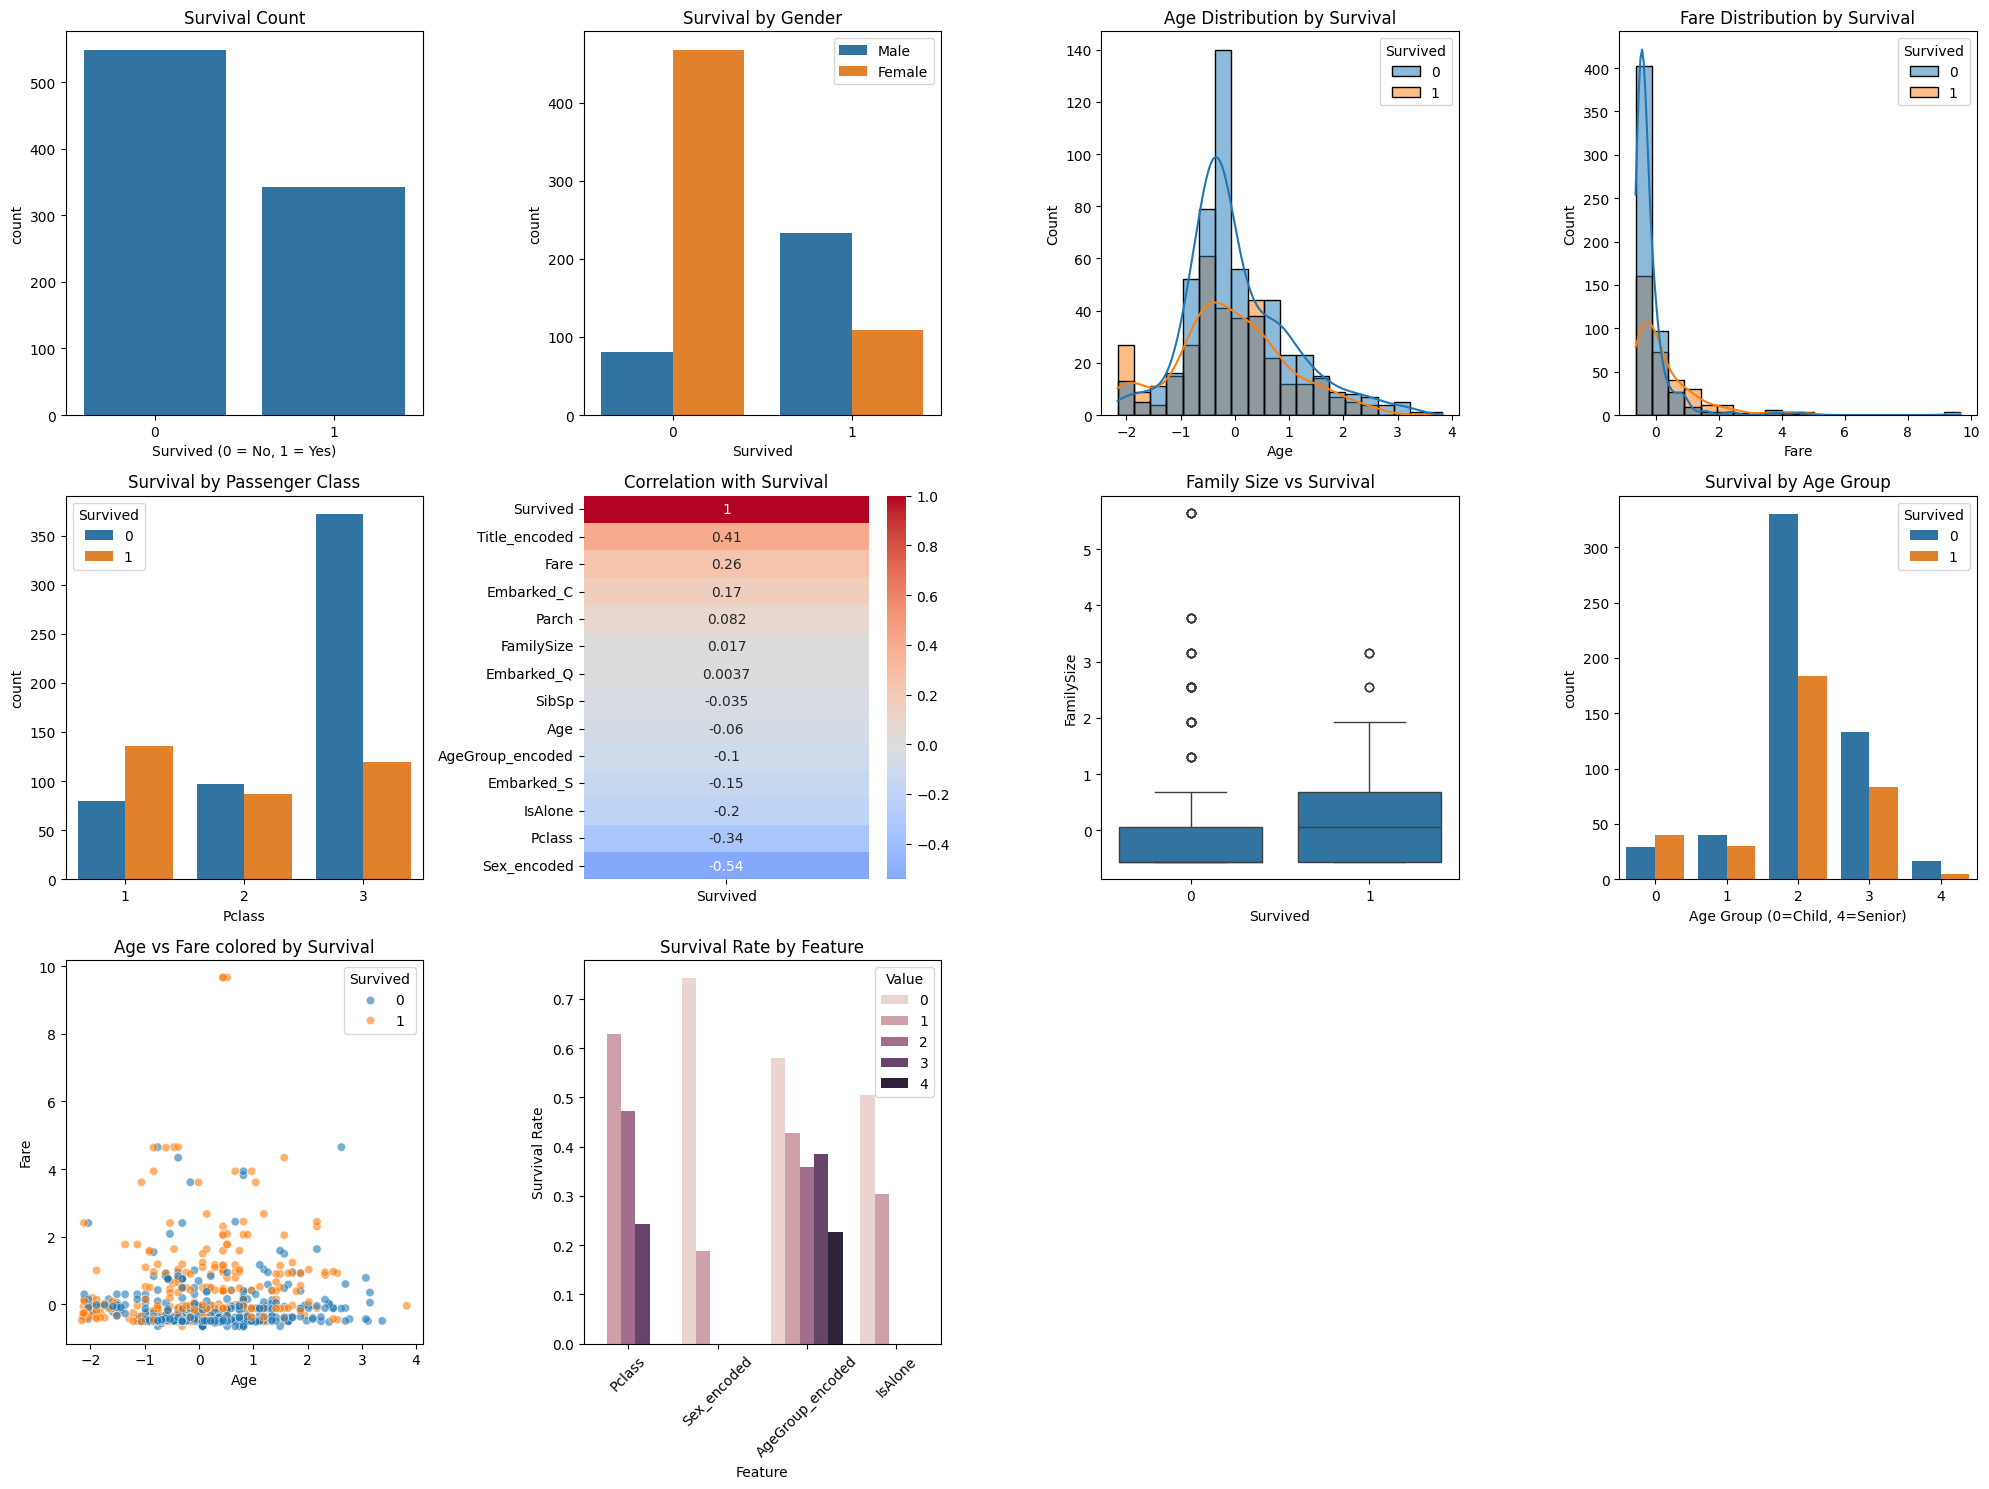

In [7]:
# Visualizations
plt.figure(figsize=(20, 15))

# Visualization 1: Survival count
plt.subplot(3, 4, 1)
sns.countplot(x='Survived', data=df_cleaned)
plt.title('Survival Count')
plt.xlabel('Survived (0 = No, 1 = Yes)')

# Visualization 2: Survival by gender
plt.subplot(3, 4, 2)
sns.countplot(x='Survived', hue='Sex_encoded', data=df_cleaned)
plt.title('Survival by Gender')
plt.legend(['Male', 'Female'])

# Visualization 3: Age distribution by survival
plt.subplot(3, 4, 3)
sns.histplot(data=df_cleaned, x='Age', hue='Survived', kde=True, bins=20)
plt.title('Age Distribution by Survival')

# Visualization 4: Fare distribution by survival
plt.subplot(3, 4, 4)
sns.histplot(data=df_cleaned, x='Fare', hue='Survived', kde=True, bins=20)
plt.title('Fare Distribution by Survival')

# Visualization 5: Survival by passenger class
plt.subplot(3, 4, 5)
sns.countplot(x='Pclass', hue='Survived', data=df_cleaned)
plt.title('Survival by Passenger Class')

# Visualization 6: Correlation heatmap
plt.subplot(3, 4, 6)
correlation_matrix = df_cleaned.corr()
sns.heatmap(correlation_matrix[['Survived']].sort_values('Survived', ascending=False),
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlation with Survival')

# Visualization 7: Family size vs survival
plt.subplot(3, 4, 7)
sns.boxplot(x='Survived', y='FamilySize', data=df_cleaned)
plt.title('Family Size vs Survival')

# Visualization 8: Age group survival
plt.subplot(3, 4, 8)
sns.countplot(x='AgeGroup_encoded', hue='Survived', data=df_cleaned)
plt.title('Survival by Age Group')
plt.xlabel('Age Group (0=Child, 4=Senior)')

# Visualization 9: Scatter plot - Age vs Fare
plt.subplot(3, 4, 9)
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=df_cleaned, alpha=0.6)
plt.title('Age vs Fare colored by Survival')

# Visualization 10: Survival rate by features
plt.subplot(3, 4, 10)
features_to_plot = ['Pclass', 'Sex_encoded', 'AgeGroup_encoded', 'IsAlone']
survival_rates = []

for feature in features_to_plot:
    rates = df_cleaned.groupby(feature)['Survived'].mean()
    for value, rate in rates.items():
        survival_rates.append({'Feature': feature, 'Value': value, 'Survival Rate': rate})

survival_df = pd.DataFrame(survival_rates)
sns.barplot(x='Feature', y='Survival Rate', hue='Value', data=survival_df)
plt.title('Survival Rate by Feature')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

** Outlier detection**

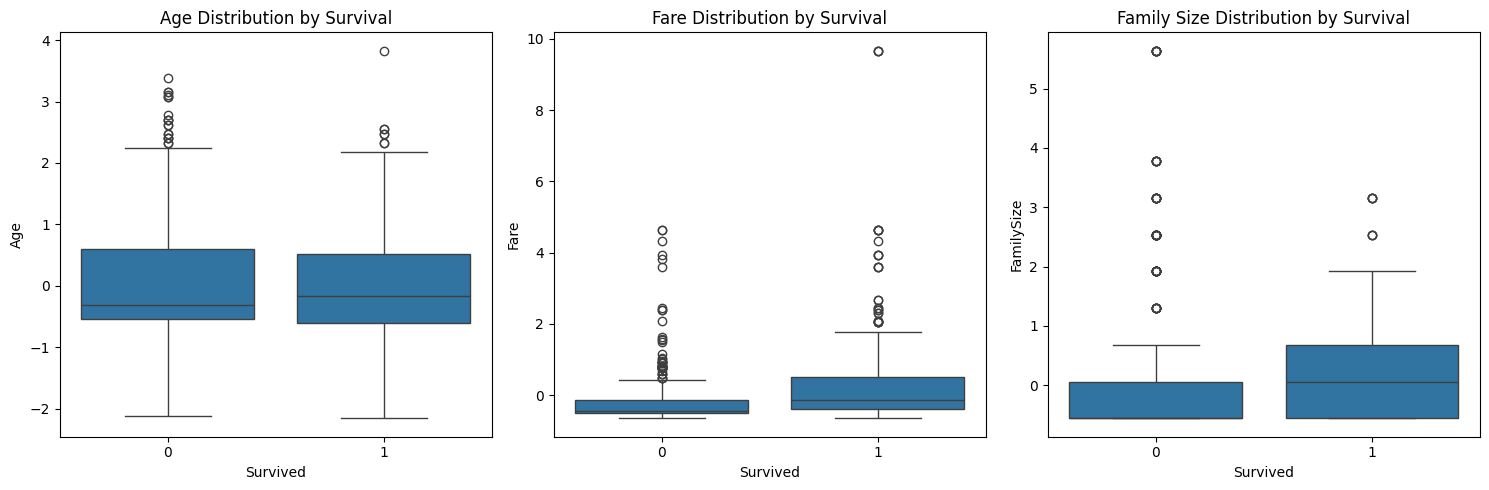

In [8]:
# Outlier detection
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='Survived', y='Age', data=df_cleaned)
plt.title('Age Distribution by Survival')

plt.subplot(1, 3, 2)
sns.boxplot(x='Survived', y='Fare', data=df_cleaned)
plt.title('Fare Distribution by Survival')

plt.subplot(1, 3, 3)
sns.boxplot(x='Survived', y='FamilySize', data=df_cleaned)
plt.title('Family Size Distribution by Survival')

plt.tight_layout()
plt.show()

**Prepare data for modeling**

In [9]:
# Prepare data for modeling
X = df_cleaned.drop('Survived', axis=1)
y = df_cleaned['Survived']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Survival rate in training set: {y_train.mean():.2%}")
print(f"Survival rate in test set: {y_test.mean():.2%}")

Training set size: (712, 13)
Test set size: (179, 13)
Survival rate in training set: 38.34%
Survival rate in test set: 38.55%


**Initialize models**

In [10]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(random_state=42, probability=True)  # probability=True for ROC curve
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\n=== Training {name} ===")

    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")


=== Training Logistic Regression ===
Logistic Regression Results:
Accuracy: 0.8156
Precision: 0.7903
Recall: 0.7101
F1-Score: 0.7481

=== Training SVM ===
SVM Results:
Accuracy: 0.8268
Precision: 0.7879
Recall: 0.7536
F1-Score: 0.7704


**Confusion matrices**

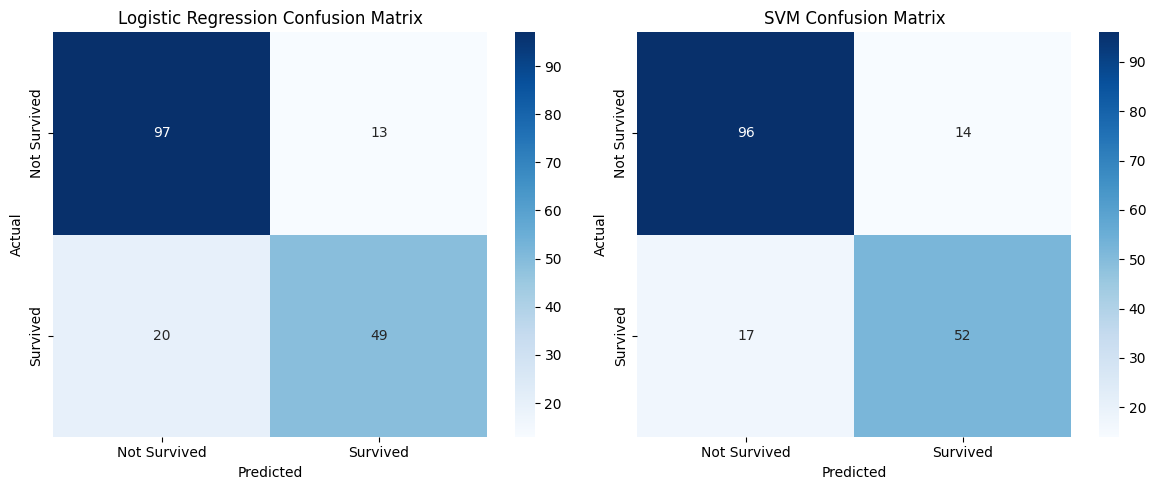


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       110
           1       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       110
           1       0.79      0.75      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



In [11]:
# Confusion matrices
plt.figure(figsize=(12, 5))

for i, (name, result) in enumerate(results.items(), 1):
    plt.subplot(1, 2, i)
    cm = confusion_matrix(y_test, result['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Survived', 'Survived'],
                yticklabels=['Not Survived', 'Survived'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Detailed classification reports
for name, result in results.items():
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, result['predictions']))

 **ROC Curves**

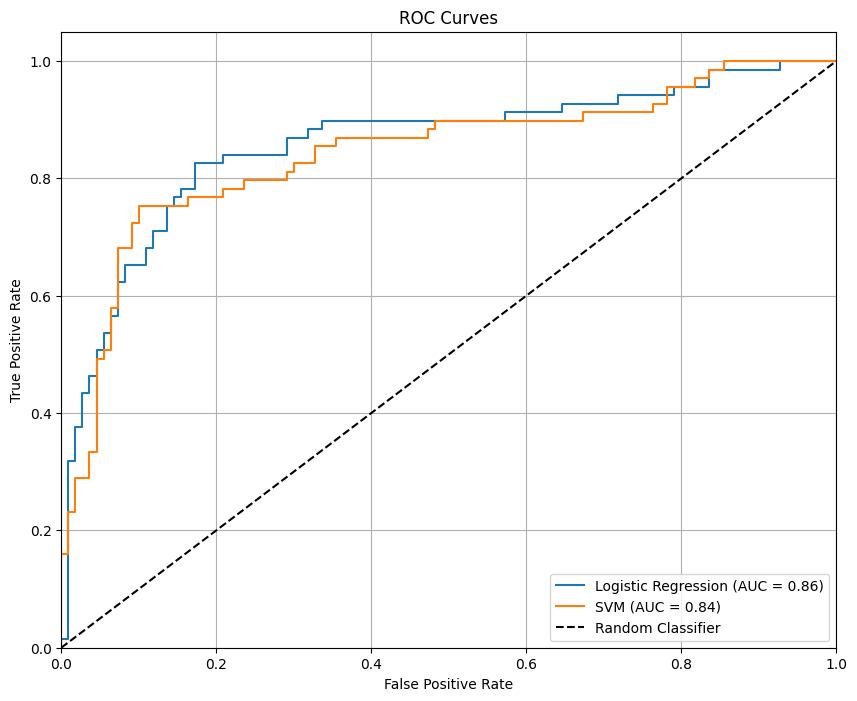

In [12]:
# ROC Curves
plt.figure(figsize=(10, 8))

for name, result in results.items():
    if result['probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**Hyperparameter tuning for Logistic Regression**

In [13]:
# Hyperparameter tuning for Logistic Regression
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000, 2000]
}

lr_grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=lr_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Tuning Logistic Regression...")
lr_grid_search.fit(X_train, y_train)

print("Best parameters for Logistic Regression:", lr_grid_search.best_params_)
print("Best cross-validation score:", lr_grid_search.best_score_)

Tuning Logistic Regression...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for Logistic Regression: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation score: 0.823086772382547


**Hyperparameter tuning for SVM**

In [14]:
# Hyperparameter tuning for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1],
    'degree': [2, 3, 4]  # Only used for poly kernel
}

svm_grid_search = RandomizedSearchCV(
    estimator=SVC(random_state=42, probability=True),
    param_distributions=svm_param_grid,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Tuning SVM...")
svm_grid_search.fit(X_train, y_train)

print("Best parameters for SVM:", svm_grid_search.best_params_)
print("Best cross-validation score:", svm_grid_search.best_score_)

Tuning SVM...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for SVM: {'kernel': 'poly', 'gamma': 0.1, 'degree': 3, 'C': 1}
Best cross-validation score: 0.8230572244656752


**Evaluate tuned models**

In [15]:
# Evaluate tuned models
tuned_models = {
    'Tuned Logistic Regression': lr_grid_search.best_estimator_,
    'Tuned SVM': svm_grid_search.best_estimator_
}

tuned_results = {}

for name, model in tuned_models.items():
    print(f"\n=== Evaluating {name} ===")

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results
    tuned_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")


=== Evaluating Tuned Logistic Regression ===
Tuned Logistic Regression Results:
Accuracy: 0.8268
Precision: 0.7969
Recall: 0.7391
F1-Score: 0.7669

=== Evaluating Tuned SVM ===
Tuned SVM Results:
Accuracy: 0.8268
Precision: 0.8393
Recall: 0.6812
F1-Score: 0.7520


**Compare before and after tuning**


=== COMPARISON BEFORE VS AFTER TUNING ===
                       Model  Accuracy  Precision    Recall  F1-Score  \
0        Logistic Regression  0.815642   0.790323  0.710145  0.748092   
1  Tuned Logistic Regression  0.826816   0.796875  0.739130  0.766917   
2                        SVM  0.826816   0.787879  0.753623  0.770370   
3                  Tuned SVM  0.826816   0.839286  0.681159  0.752000   

            Type  
0  Before Tuning  
1   After Tuning  
2  Before Tuning  
3   After Tuning  


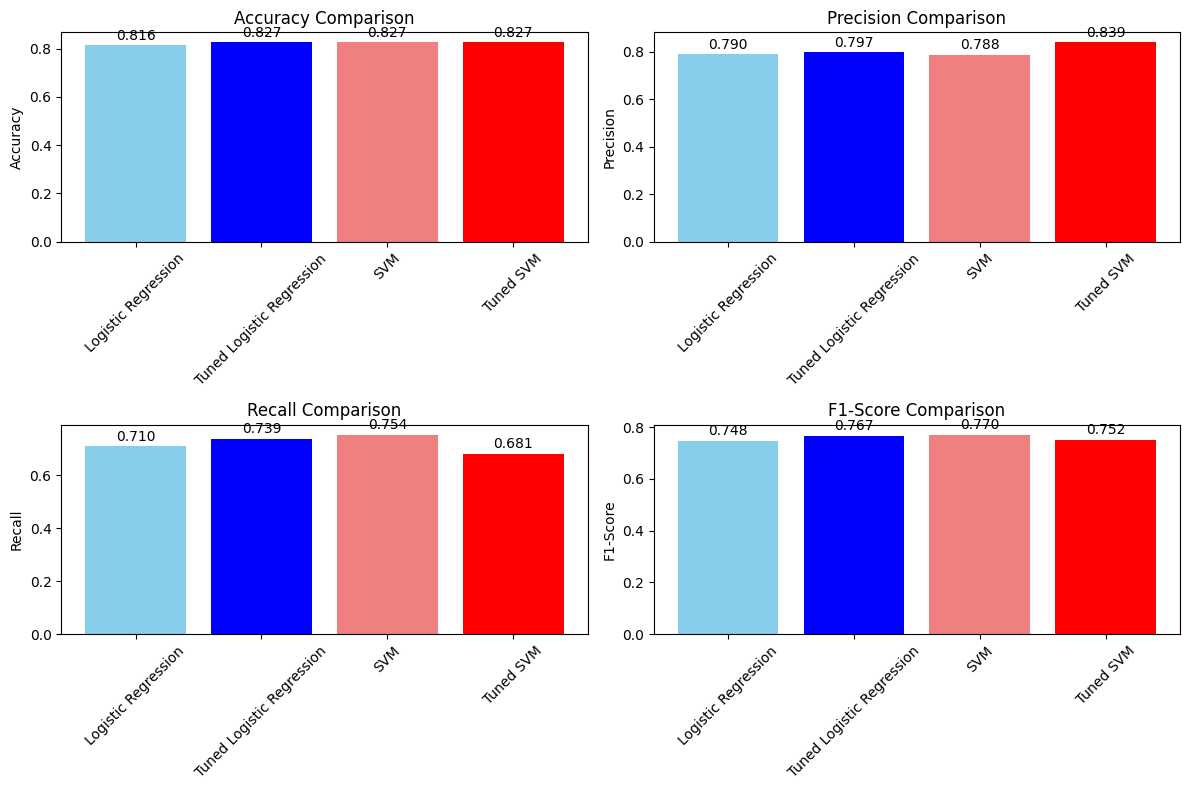

In [16]:
# Compare before and after tuning
comparison_data = []

for name in ['Logistic Regression', 'SVM']:
    # Original results
    comparison_data.append({
        'Model': name,
        'Accuracy': results[name]['accuracy'],
        'Precision': results[name]['precision'],
        'Recall': results[name]['recall'],
        'F1-Score': results[name]['f1_score'],
        'Type': 'Before Tuning'
    })

    # Tuned results
    tuned_name = f'Tuned {name}'
    comparison_data.append({
        'Model': tuned_name,
        'Accuracy': tuned_results[tuned_name]['accuracy'],
        'Precision': tuned_results[tuned_name]['precision'],
        'Recall': tuned_results[tuned_name]['recall'],
        'F1-Score': tuned_results[tuned_name]['f1_score'],
        'Type': 'After Tuning'
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n=== COMPARISON BEFORE VS AFTER TUNING ===")
print(comparison_df)

# Visualization of comparison
plt.figure(figsize=(12, 8))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
models_compare = ['Logistic Regression', 'Tuned Logistic Regression', 'SVM', 'Tuned SVM']

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    values = [comparison_df[comparison_df['Model'] == model][metric].values[0] for model in models_compare]
    bars = plt.bar(models_compare, values, color=['skyblue', 'blue', 'lightcoral', 'red'])
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)
    plt.ylabel(metric)

    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Feature importance for Logistic Regression**

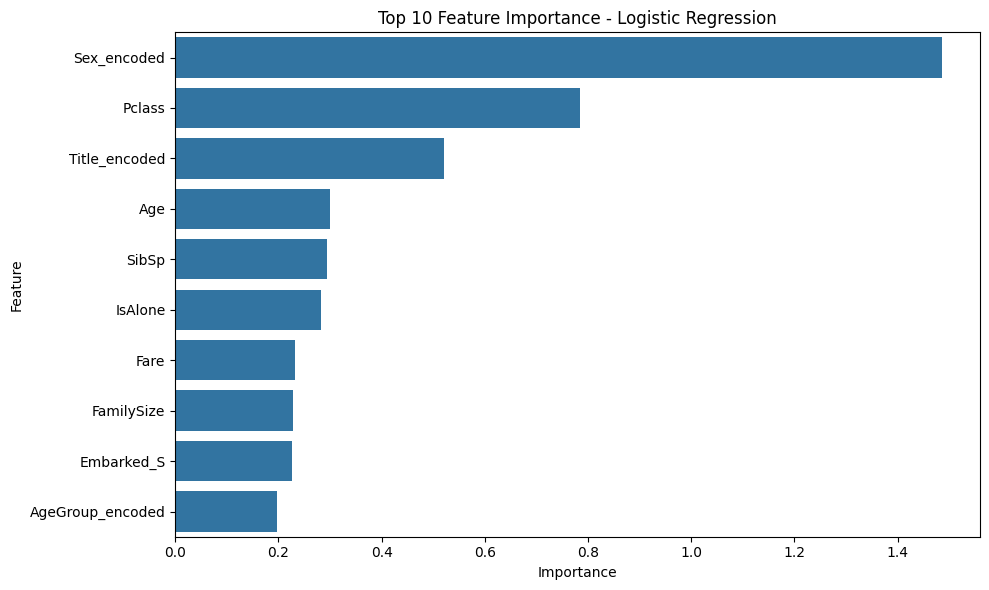

Feature Importance (Logistic Regression):
             Feature  Importance
5        Sex_encoded    1.485436
0             Pclass    0.783904
9      Title_encoded    0.521680
1                Age    0.300949
2              SibSp    0.294498
11           IsAlone    0.282660
4               Fare    0.233160
10        FamilySize    0.227482
8         Embarked_S    0.227101
12  AgeGroup_encoded    0.197689
7         Embarked_Q    0.176508
6         Embarked_C    0.057713
3              Parch    0.052449


In [17]:
# Feature importance for Logistic Regression
lr_model = tuned_models['Tuned Logistic Regression']

if hasattr(lr_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': abs(lr_model.coef_[0])
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
    plt.title('Top 10 Feature Importance - Logistic Regression')
    plt.tight_layout()
    plt.show()

    print("Feature Importance (Logistic Regression):")
    print(feature_importance)

In [18]:
# Save the trained models and preprocessing objects
import joblib

# Save the best models
joblib.dump(tuned_models['Tuned Logistic Regression'], 'logistic_regression_model.pkl')
joblib.dump(tuned_models['Tuned SVM'], 'svm_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Models and preprocessing objects saved successfully!")

Models and preprocessing objects saved successfully!


In [19]:
joblib.dump(tuned_models['Tuned Logistic Regression'], 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

In [20]:
joblib.dump(tuned_models['Tuned SVM'], 'svm_model.pkl')


['svm_model.pkl']

In [22]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']